In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv("data/deponieanlieferungen-tufentobel.csv", delimiter=';')

#Check for missing values
missing_values = df.isna().sum()
missing_values

#missing values are in column "Kanton" with only 94 values missing
#also, the there are no relevant outliers in these 94 values
df[df['Kanton'].isna()].describe()

#drop missing values for Kanton
df.dropna(subset=['Kanton'], inplace=True)

#check where the anlieferungen are zero tons
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#remove these values
df.drop(df[df['Gewicht in Tonnen'] == 0].index, inplace=True)

#test if it worked
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#check very small values
#print(df[df['Gewicht in Tonnen'] < 0.1].value_counts().sum())

#check duplicates
duplicates = df.duplicated()
#print(f"Number of duplicate rows: {duplicates.sum()}")

# #Visualize the outliers in a plot
# plt.figure(figsize=(10, 6))
# plt.boxplot(df['Gewicht in Tonnen'], vert=False)
# plt.title('Boxplot of Gewicht in Tonnen')
# plt.xlabel('Gewicht in Tonnen')
# plt.show()


# df[df['Gewicht in Tonnen'] > 35]

#there is one outlier with 56.7 tons, the other values dont go over 35 tons
#remove this outlier
df.drop(df[df['Gewicht in Tonnen'] > 50].index, inplace=True)

#Time series decomposition

# Convert the date column to datetime
df['Anlieferungsdatum'] = pd.to_datetime(df['Anlieferungsdatum'], utc=True)

# # Set the date column as the index
# df.set_index('Anlieferungsdatum', inplace=True)

In [126]:
df = df[["Anlieferungsdatum", "Material", "Gewicht in Tonnen"]]

In [127]:
df = df[df["Material"] == "Inertstoffe"]
df = df.drop(columns=["Material"])
df = df.resample('D', on='Anlieferungsdatum').sum()

In [128]:
df

,Gewicht in Tonnen
Anlieferungsdatum,
2019-01-07 00:00:00+00:00,74.08
2019-01-08 00:00:00+00:00,22.96
2019-01-09 00:00:00+00:00,25.04
2019-01-14 00:00:00+00:00,24.96
2019-01-15 00:00:00+00:00,121.88
...,...
2024-02-22 00:00:00+00:00,156.56
2024-02-23 00:00:00+00:00,167.80
2024-02-26 00:00:00+00:00,435.98


In [123]:
# Resample the data to daily frequency
daily_data = df['Gewicht in Tonnen'].resample('D').sum()
daily_data

Anlieferungsdatum
2019-01-07 00:00:00+00:00     74.08
2019-01-08 00:00:00+00:00     22.96
2019-01-09 00:00:00+00:00     25.04
2019-01-10 00:00:00+00:00      0.00
2019-01-11 00:00:00+00:00      0.00
                              ...  
2024-02-24 00:00:00+00:00      0.00
2024-02-25 00:00:00+00:00      0.00
2024-02-26 00:00:00+00:00    435.98
2024-02-27 00:00:00+00:00    343.96
2024-02-28 00:00:00+00:00    336.28
Freq: D, Name: Gewicht in Tonnen, Length: 1879, dtype: float64

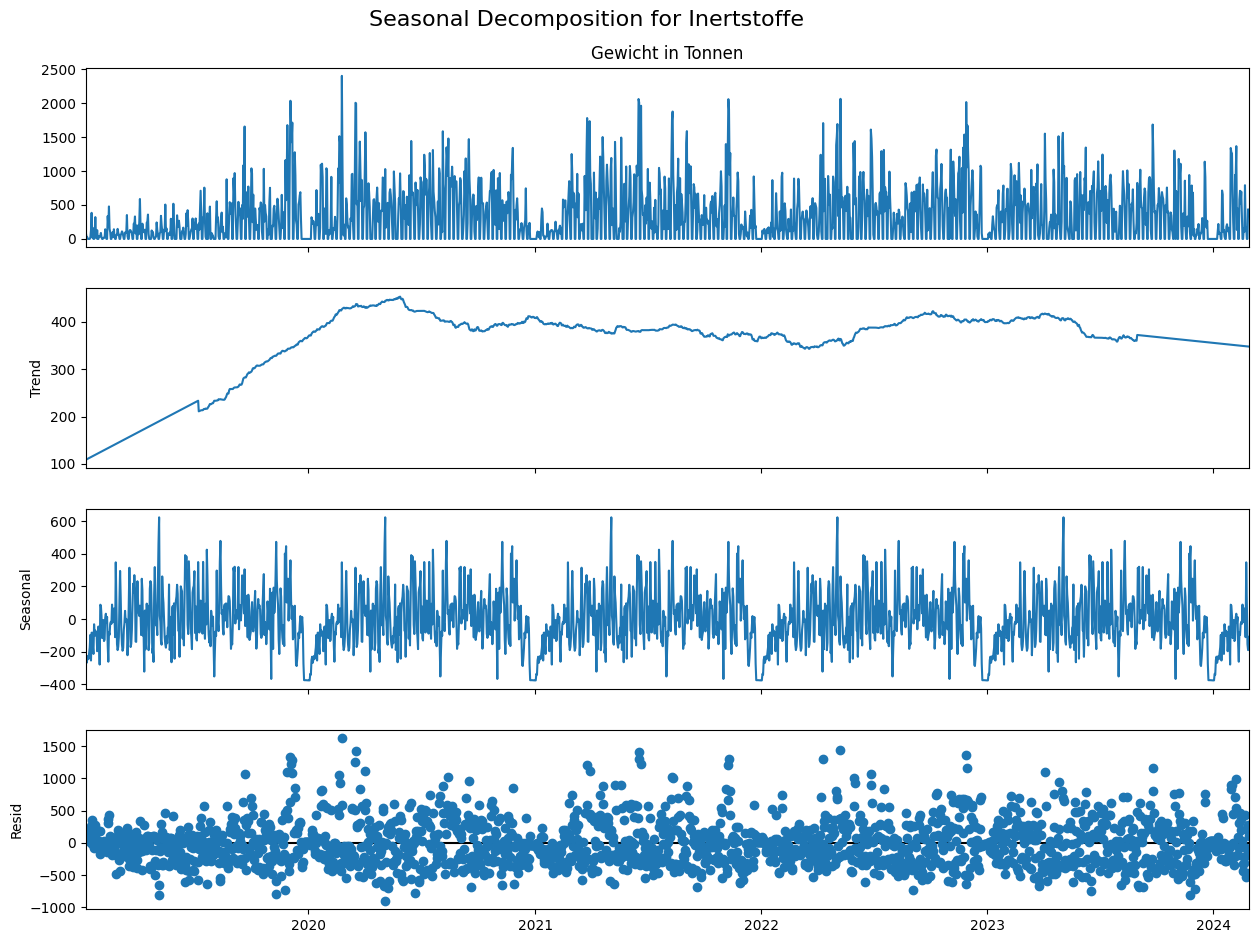

In [97]:

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive', period=365, extrapolate_trend='freq')

# Plot the decomposition
# Extract trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Seasonal Decomposition for Inertstoffe', fontsize=16)
plt.show()

Decomposition

In [98]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(daily_data)

# Extract and print the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print("Critical Values:", adf_result[4])

ADF Statistic: -6.105898153722116
p-value: 9.58681827917579e-08
Critical Values: {'1%': np.float64(-3.4338839352172137), '5%': np.float64(-2.8631010343251675), '10%': np.float64(-2.5676010393524713)}


The ADF Statistic 
−
6.1059
−6.1059 is more negative than the critical values at all levels (1%, 5%, 10%).
The p-value is much smaller than 
0.05
0.05, providing strong evidence to reject the null hypothesis.
Conclusion:
The time series is stationary at all commonly used significance levels.

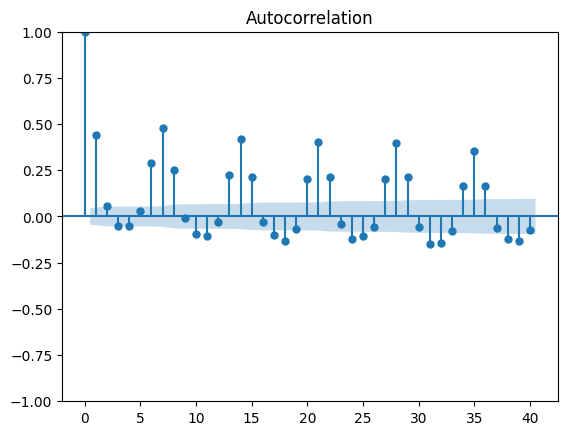

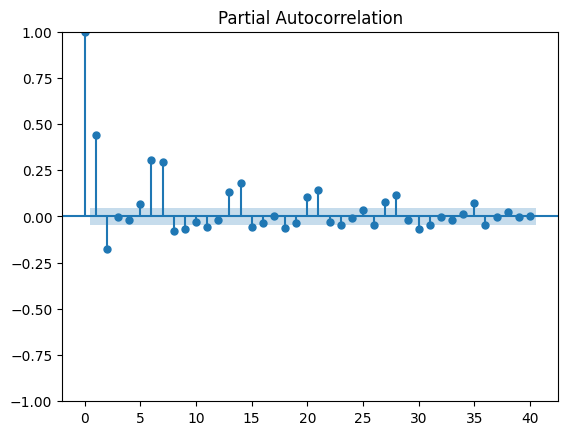

In [99]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(daily_data, lags=40)
plot_pacf(daily_data, lags=40)
plt.show()


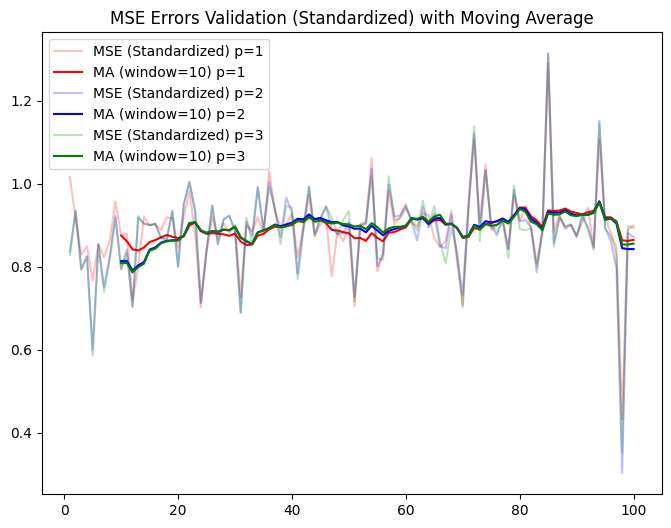

In [130]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# --- 1. Daten laden ---
# Beispiel: daily_data = pd.Series(...) (Deine Zeitreihe)

# --- 2. Saisonalität und Trend extrahieren ---
# Additive Dekomposition
# decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive', period=365, extrapolate_trend='freq')
# trend = decomposition.trend
# seasonal = decomposition.seasonal

# --- 3. ARIMA-Parameter ---
p, d, q = 1, 0, 1

# --- 4. Daten-Splitting ---
test_size = 300  # Größe des unabhängigen Tests
validate_size = 10  # Größe jedes Validation-Splits
train_validate_size = len(daily_data) - test_size  # Rest als Train + Validate

# Daten aufteilen
train_validate_data = daily_data[:train_validate_size]
test_data = daily_data[train_validate_size:]
trend_train_validate = trend[:train_validate_size]
trend_test = trend[train_validate_size:]
seasonal_train_validate = seasonal[:train_validate_size]
seasonal_test = seasonal[train_validate_size:]

# --- 5. Rolling Validation ---
n_splits = 100
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=validate_size)

# Error lists
colors = ["red", "blue", "green", "orange"]

plt.figure(figsize=(8, 6))
for p in range(1, 4):
    validate_errors = []
    standardized_validate_errors = []
    # --- 6. Training und Validierung ---
    for i, (train_index, validate_index) in enumerate(tscv.split(train_validate_data)):
        # Train und Validate Splits erstellen
        train, validate = train_validate_data.iloc[train_index], train_validate_data.iloc[validate_index]
        trend_train, trend_validate = trend_train_validate.iloc[train_index], trend_train_validate.iloc[validate_index]
        seasonal_train, seasonal_validate = seasonal_train_validate.iloc[train_index], seasonal_train_validate.iloc[validate_index]
        
        # TRAINING
        # Detrend und Deseasonalize
        train_residual = train - trend_train - seasonal_train
        # Standardize
        train_mean, train_std = train_residual.mean(), train_residual.std()
        train_standardized = (train_residual - train_mean) / train_std
        
        # VALIDATION
        # Detrend und Deseasonalize
        validate_residual = validate - trend_validate - seasonal_validate
        # Standardize
        validate_mean, validate_std = validate_residual.mean(), validate_residual.std()
        validate_standardized = (validate_residual - validate_mean) / validate_std

        # Fit ARIMA-model on training split
        model = ARIMA(train_standardized, order=(p, d, q))
        model_fit = model.fit()
        
        # Vorhersage auf Validation-Split
        forecast_standardized = model_fit.forecast(steps=len(validate_standardized))


        # Validationsfehler (Standardized)
        standardized_error = mean_squared_error(validate_standardized, forecast_standardized)
        standardized_validate_errors.append(standardized_error)
        
        # # Revert Standardization
        # forecast_residual = forecast_standardized * train_std + train_mean
        
        # # Trend und Saisonalität hinzufügen
        # final_forecast = forecast_residual + trend_validate + seasonal_validate
        
        # # Validationsfehler (Original-Skala)
        # validate_error = mean_squared_error(validate, final_forecast)
        # validate_errors.append(validate_error)
        
        # # Print Validate Errors
        # print(f"Iteration {i+1}, Validation Error (MSE - Original Scale): {validate_error:.4f}")
        # print(f"Iteration {i+1}, Validation Error (MSE - Standardized): {standardized_error:.4f}")

    # --- 7. Plot Test Results ---
    window_size = 10
    moving_avg_errors = pd.Series(standardized_validate_errors).rolling(window=window_size).mean()

    plt.plot(range(1, n_splits+1), standardized_validate_errors, label=f"MSE (Standardized) p={p}", color=colors[p-1], alpha=0.25)
    plt.plot(range(1, n_splits+1), moving_avg_errors, label=f"MA (window={window_size}) p={p}", color=colors[p-1])
plt.title("MSE Errors Validation (Standardized) with Moving Average")
plt.legend()
plt.show()